# <center><span lang=EN-US style='color:red'>Data Pre-processing</span></center> 
## <center><span lang=EN-US style='color:red'>Handling data</span></center>
### <center>Jupyter Notebook for data preparation</center>

##### <center><a href="http://www.oacn.inaf.it/~brescia/">Massimo Brescia</a></center>

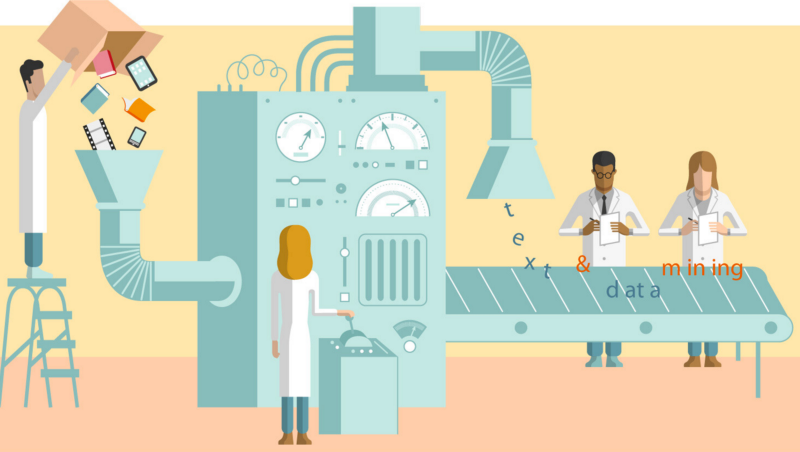

# Building Good Training Sets – Data Pre-Processing

### Overview

- [Dealing with missing data](#Dealing-with-missing-data)
  - [Eliminating samples or features with missing values](#Eliminating-samples-or-features-with-missing-values)
  - [Imputing missing values](#Imputing-missing-values)
  - [Imputing with KNN](#K-Nearest-Neighbors-imputation)
- [Handling categorical data](#Handling-categorical-data)
  - [Mapping ordinal features](#Mapping-ordinal-features)
  - [Encoding class labels](#Encoding-class-labels)
- [Partitioning a dataset in training and test sets](#Partitioning-a-dataset-in-training-and-test-sets)
- [Bringing features onto the same scale](#Bringing-features-onto-the-same-scale)
- [Selecting meaningful features](#Selecting-meaningful-features)
  - [Sparse solutions with L1 regularization](#Sparse-solutions-with-L1-regularization)
  - [Sequential feature selection algorithms](#Sequential-feature-selection-algorithms)
- [Assessing feature importance with random forests](#Assessing-feature-importance-with-random-forests)

In [1]:
from IPython.display import Image
import matplotlib, sklearn, distutils

# Dealing with missing data

In [3]:
import pandas as pd
from io import StringIO

csv_data = '''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


isnull() is a pandas function detecting missing values for an array-like object.
This function takes a scalar or array-like object and indicates whether values are missing (NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike).

In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## Eliminating samples or features with missing values

dropna() is a function that returns a new array-like object with missing values removed. Without arguments it works on axis=0 (in this case rows of the matrix).

In [5]:
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
df.dropna(axis=1) # drops columns with NaN

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [7]:
# forced to show all data
df.dropna(how='all')  

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [8]:
# drop rows that have at least 4 non-NaN values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [9]:
# only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


## Imputing missing values

As seen above, the basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data.

In [10]:
import numpy as np

adf = [[1.0,2.0,3.0,4.0],
       [5.0,6.0,np.nan,8.0],
       [10.0,11.0,12.0,np.nan]]
print(adf)
adf = np.array(adf)
adf

[[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, nan, 8.0], [10.0, 11.0, 12.0, nan]]


array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

From scikit-learn V0.20, there is a special class <a href="https://scikit-learn.org/stable/modules/impute.html">imputing</a> dedicated to such kind of problem.

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer">SimpleImputer</a> is an object able to perform imputation of types "mean", "median", "most_frequent" and "constant" <strong>on array columns</strong>

In [11]:
from sklearn.impute import SimpleImputer

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(adf)
imputed_data = imr.transform(adf)
print("mean-based imputation:")
print(imputed_data)

mean-based imputation:
[[ 1.   2.   3.   4. ]
 [ 5.   6.   7.5  8. ]
 [10.  11.  12.   6. ]]


In [12]:
imr = SimpleImputer(missing_values=np.nan, strategy='median')
imr = imr.fit(adf)
imputed_data = imr.transform(adf)
print("median-based imputation:")
print(imputed_data)

median-based imputation:
[[ 1.   2.   3.   4. ]
 [ 5.   6.   7.5  8. ]
 [10.  11.  12.   6. ]]


In [13]:
imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imr = imr.fit(adf)
imputed_data = imr.transform(adf)
print("frequency-based imputation:")
print(imputed_data)

frequency-based imputation:
[[ 1.  2.  3.  4.]
 [ 5.  6.  3.  8.]
 [10. 11. 12.  4.]]


In [14]:
imr = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=42.)
imr = imr.fit(adf)
imputed_data = imr.transform(adf)
print("constant-based imputation:")
print(imputed_data)

constant-based imputation:
[[ 1.  2.  3.  4.]
 [ 5.  6. 42.  8.]
 [10. 11. 12. 42.]]


## K-Nearest Neighbors imputation

The scikit-learn <strong>KNNImputer</strong> class provides imputation for replacing missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, i.e. <i>nan_euclidean_distances</i>, is used to find the nearest neighbors. Each missing feature is imputed using values from <i>n_neighbors</i> nearest neighbors that have a value for the feature. 

In [15]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(adf)

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In the real world, missing data are often marked with a special number (typically -999.99). In such cases, before to handle such entries, it is more convenient to replace them with the typical numpy.nan type, to prevent problems. To do this, instead of a long code (made by a cycle on all array entries), the <strong>numpy.where()</strong> function is helpful and elegant:

In [16]:
adf2 = [[1.0,2.0,3.0,4.0],
       [5.0,6.0,-999.99,8.0],
       [10.0,11.0,12.0,-999.99]]
adf2 = np.array(adf2)
print("Before replacement: ")
print(adf2)
# the third argument, np.nan, is called a "broadcast"
adf2 = np.where(adf2 != -999.99, adf2, np.nan)
print("After replacement: ")
print(adf2)
imr = imr.fit(adf2)
imputed_data = imr.transform(adf2)
print("After mean-based imputation: ")
print(imputed_data)

Before replacement: 
[[   1.      2.      3.      4.  ]
 [   5.      6.   -999.99    8.  ]
 [  10.     11.     12.   -999.99]]
After replacement: 
[[ 1.  2.  3.  4.]
 [ 5.  6. nan  8.]
 [10. 11. 12. nan]]
After mean-based imputation: 
[[ 1.  2.  3.  4.]
 [ 5.  6. 42.  8.]
 [10. 11. 12. 42.]]


# Handling categorical data

Sometimes data can be composed by a mix of numerical and categorical entries:

In [17]:
import pandas as pd

df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


## Mapping ordinal features

It could be useful to replace categories with some ordinal ranking: 

In [ ]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

## Encoding class labels

Also the class label should be replaced by an numerical encoding, to be easier to handle it:

In [18]:
import numpy as np

class_mapping = {label: idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [19]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,M,10.1,0
1,red,L,13.5,1
2,blue,XL,15.3,0


In [ ]:
011111110

In [ ]:
100000001

In [20]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0], dtype=int64)

# Partitioning a dataset in training and test sets

In [21]:
"""
df_wine = pd.read_csv('./wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
"""
header = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine = pd.read_csv('./wine/wine.data', names=header)

print('Class labels', np.unique(df_wine['Class label'])) # unique() finds the unique elements of an array.
df_wine.head(3)

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185


In [22]:
from sklearn.model_selection import train_test_split

#Purely integer-location based indexing for selection by position with iloc
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Now convert numpy array (returned by train_test_split() function) into a pandas dataframe, to save subsets as csv files

In [23]:
# header must be attached again, because the conversion automatically put numbers as default header
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = header[1:len(header)]
X_train_df.to_csv("xtrain.csv")

y_train_df = pd.DataFrame(y_train)
y_train_df.columns = {header[0]}
y_train_df.to_csv("ytrain.csv")

X_test_df = pd.DataFrame(X_test)
X_test_df.columns = header[1:len(header)]
X_test_df.to_csv("xtest.csv")

y_test_df = pd.DataFrame(y_test)
y_test_df.columns = {header[0]}
y_test_df.to_csv("ytest.csv")

In [24]:
print("Xtrain:")
X_train_df.head(1)

Xtrain:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.71,1.86,2.36,16.6,101.0,2.61,2.88,0.27,1.69,3.8,1.11,4.0,1035.0


In [25]:
print("ytrain:")
y_train_df.head(1)

ytrain:


,Class label
0,1


In [26]:
print("Xtest:")
X_test_df.head(1)

Xtest:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.74,1.67,2.25,16.4,118.0,2.6,2.9,0.21,1.62,5.85,0.92,3.2,1060.0


In [27]:
print("ytest:")
y_test_df.head(1)

ytest:


,Class label
0,1


# Bringing features onto the same scale

In general, Machine Learning models work better with input data comparable in terms of their numerical variance (for example, SVM is a model for which a normalization of input is highly suggested). Scikit-learn makes available the function <strong>MinMaxScaler</strong>, which transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually, such that it is in the given range on the training set, e.g. between zero and one.
The minmax transformation is given by: (X-minX)/(maxX-minX).

In [28]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
# Fit to data, then transform it.
X_train_norm = mms.fit_transform(X_train)

X_train_norm_df = pd.DataFrame(X_train_norm)
X_train_norm_df.columns = header[1:len(header)]

# Scale features of X according to feature_range.
X_test_norm = mms.transform(X_test)

X_test_norm_df = pd.DataFrame(X_test_norm)
X_test_norm_df.columns = header[1:len(header)]

In [29]:
print("original Xtrain:")
X_train_df.head(1)

original Xtrain:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.71,1.86,2.36,16.6,101.0,2.61,2.88,0.27,1.69,3.8,1.11,4.0,1035.0


In [30]:
print("minmax normalized Xtrain:")
X_train_norm_df.head(1)

minmax normalized Xtrain:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.72043,0.203782,0.537634,0.309278,0.336957,0.543165,0.737003,0.25,0.401899,0.240688,0.487179,1.0,0.585425


In [31]:
print("original Xtest:")
X_test_df.head(1)

original Xtest:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.74,1.67,2.25,16.4,118.0,2.6,2.9,0.21,1.62,5.85,0.92,3.2,1060.0


In [32]:
print("minmax normalized Xtest:")
X_test_norm_df.head(1)

minmax normalized Xtest:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.728495,0.163866,0.478495,0.298969,0.521739,0.539568,0.743119,0.134615,0.379747,0.436485,0.324786,0.70696,0.605668


An alternative could be the function <strong>StandardScaler</strong>, which standardizes features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as: z = (x - u) / s, where u is the mean of the training samples or zero if argument "with_mean" = False, and s is the standard deviation of the training samples or one if "with_std" = False.

In [33]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
# Fit to data, then transform it.
X_train_std = stdsc.fit_transform(X_train)

X_train_std_df = pd.DataFrame(X_train_std)
X_train_std_df.columns = header[1:len(header)]

# Perform standardization by centering and scaling
X_test_std = stdsc.transform(X_test)

X_test_std_df = pd.DataFrame(X_test_std)
X_test_std_df.columns = header[1:len(header)]


In [34]:
print("original Xtrain:")
X_train_df.head(1)

original Xtrain:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,13.71,1.86,2.36,16.6,101.0,2.61,2.88,0.27,1.69,3.8,1.11,4.0,1035.0


In [35]:
print("minmax normalized Xtrain:")
X_train_norm_df.head(1)

minmax normalized Xtrain:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.72043,0.203782,0.537634,0.309278,0.336957,0.543165,0.737003,0.25,0.401899,0.240688,0.487179,1.0,0.585425


In [36]:
print("standardized Xtrain:")
X_train_std_df.head(1)

standardized Xtrain:


,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,0.910831,-0.462599,-0.011426,-0.820679,0.062417,0.588204,0.935654,-0.761914,0.130072,-0.512387,0.657066,1.943545,0.93701


Alternatively, you could also perform same scaling by hands:

In [37]:
ex = pd.DataFrame([0, 1, 2, 3, 4, 5])

# standardize
ex[1] = (ex[0] - ex[0].mean()) / ex[0].std(ddof=0)

# Please note that pandas uses ddof=1 (sample standard deviation or divided by N-1) 
# by default, whereas NumPy's std method and the StandardScaler
# uses ddof=0 (population standard deviation or divided by N)

# normalize
ex[2] = (ex[0] - ex[0].min()) / (ex[0].max() - ex[0].min())
ex.columns = ['input', 'standardized', 'normalized']
ex

,input,standardized,normalized
0,0,-1.46385,0.0
1,1,-0.87831,0.2
2,2,-0.29277,0.4
3,3,0.29277,0.6
4,4,0.87831,0.8
5,5,1.46385,1.0


# Selecting meaningful features

## Sparse solutions with L2-regularization

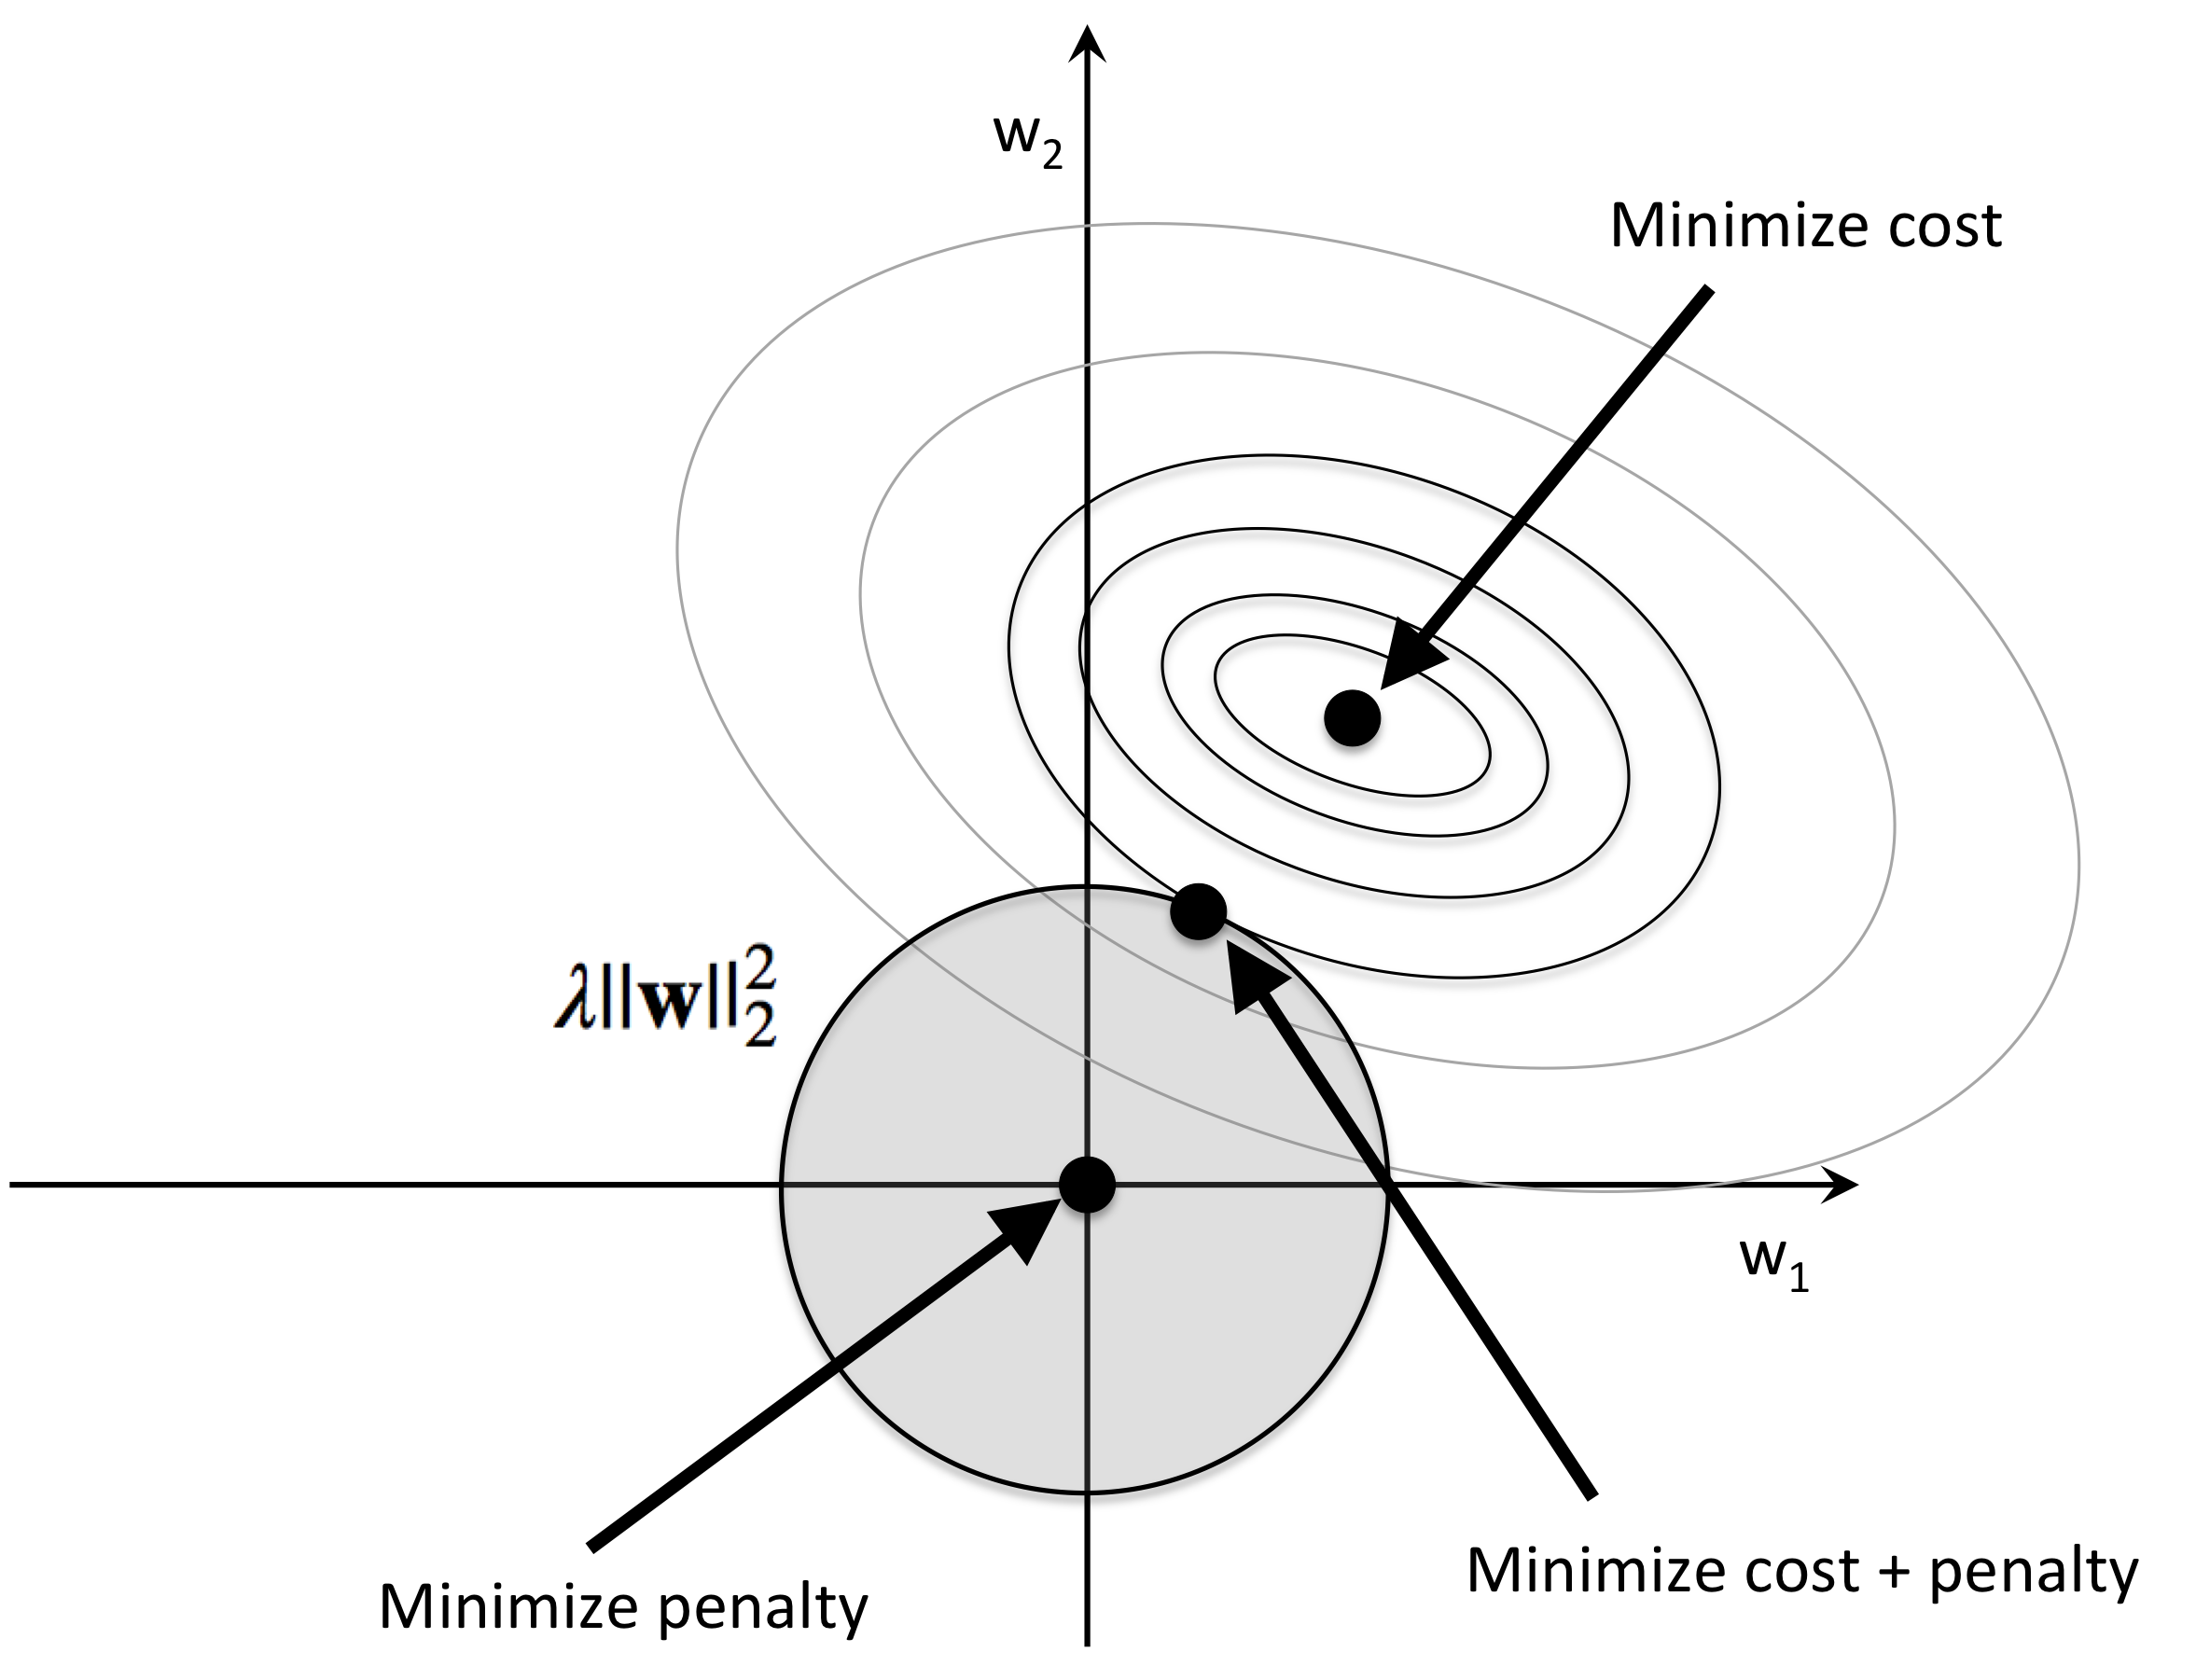

In [38]:
Image(filename='./04_12.png', width=500) 

## Sparse solutions with L1-regularization

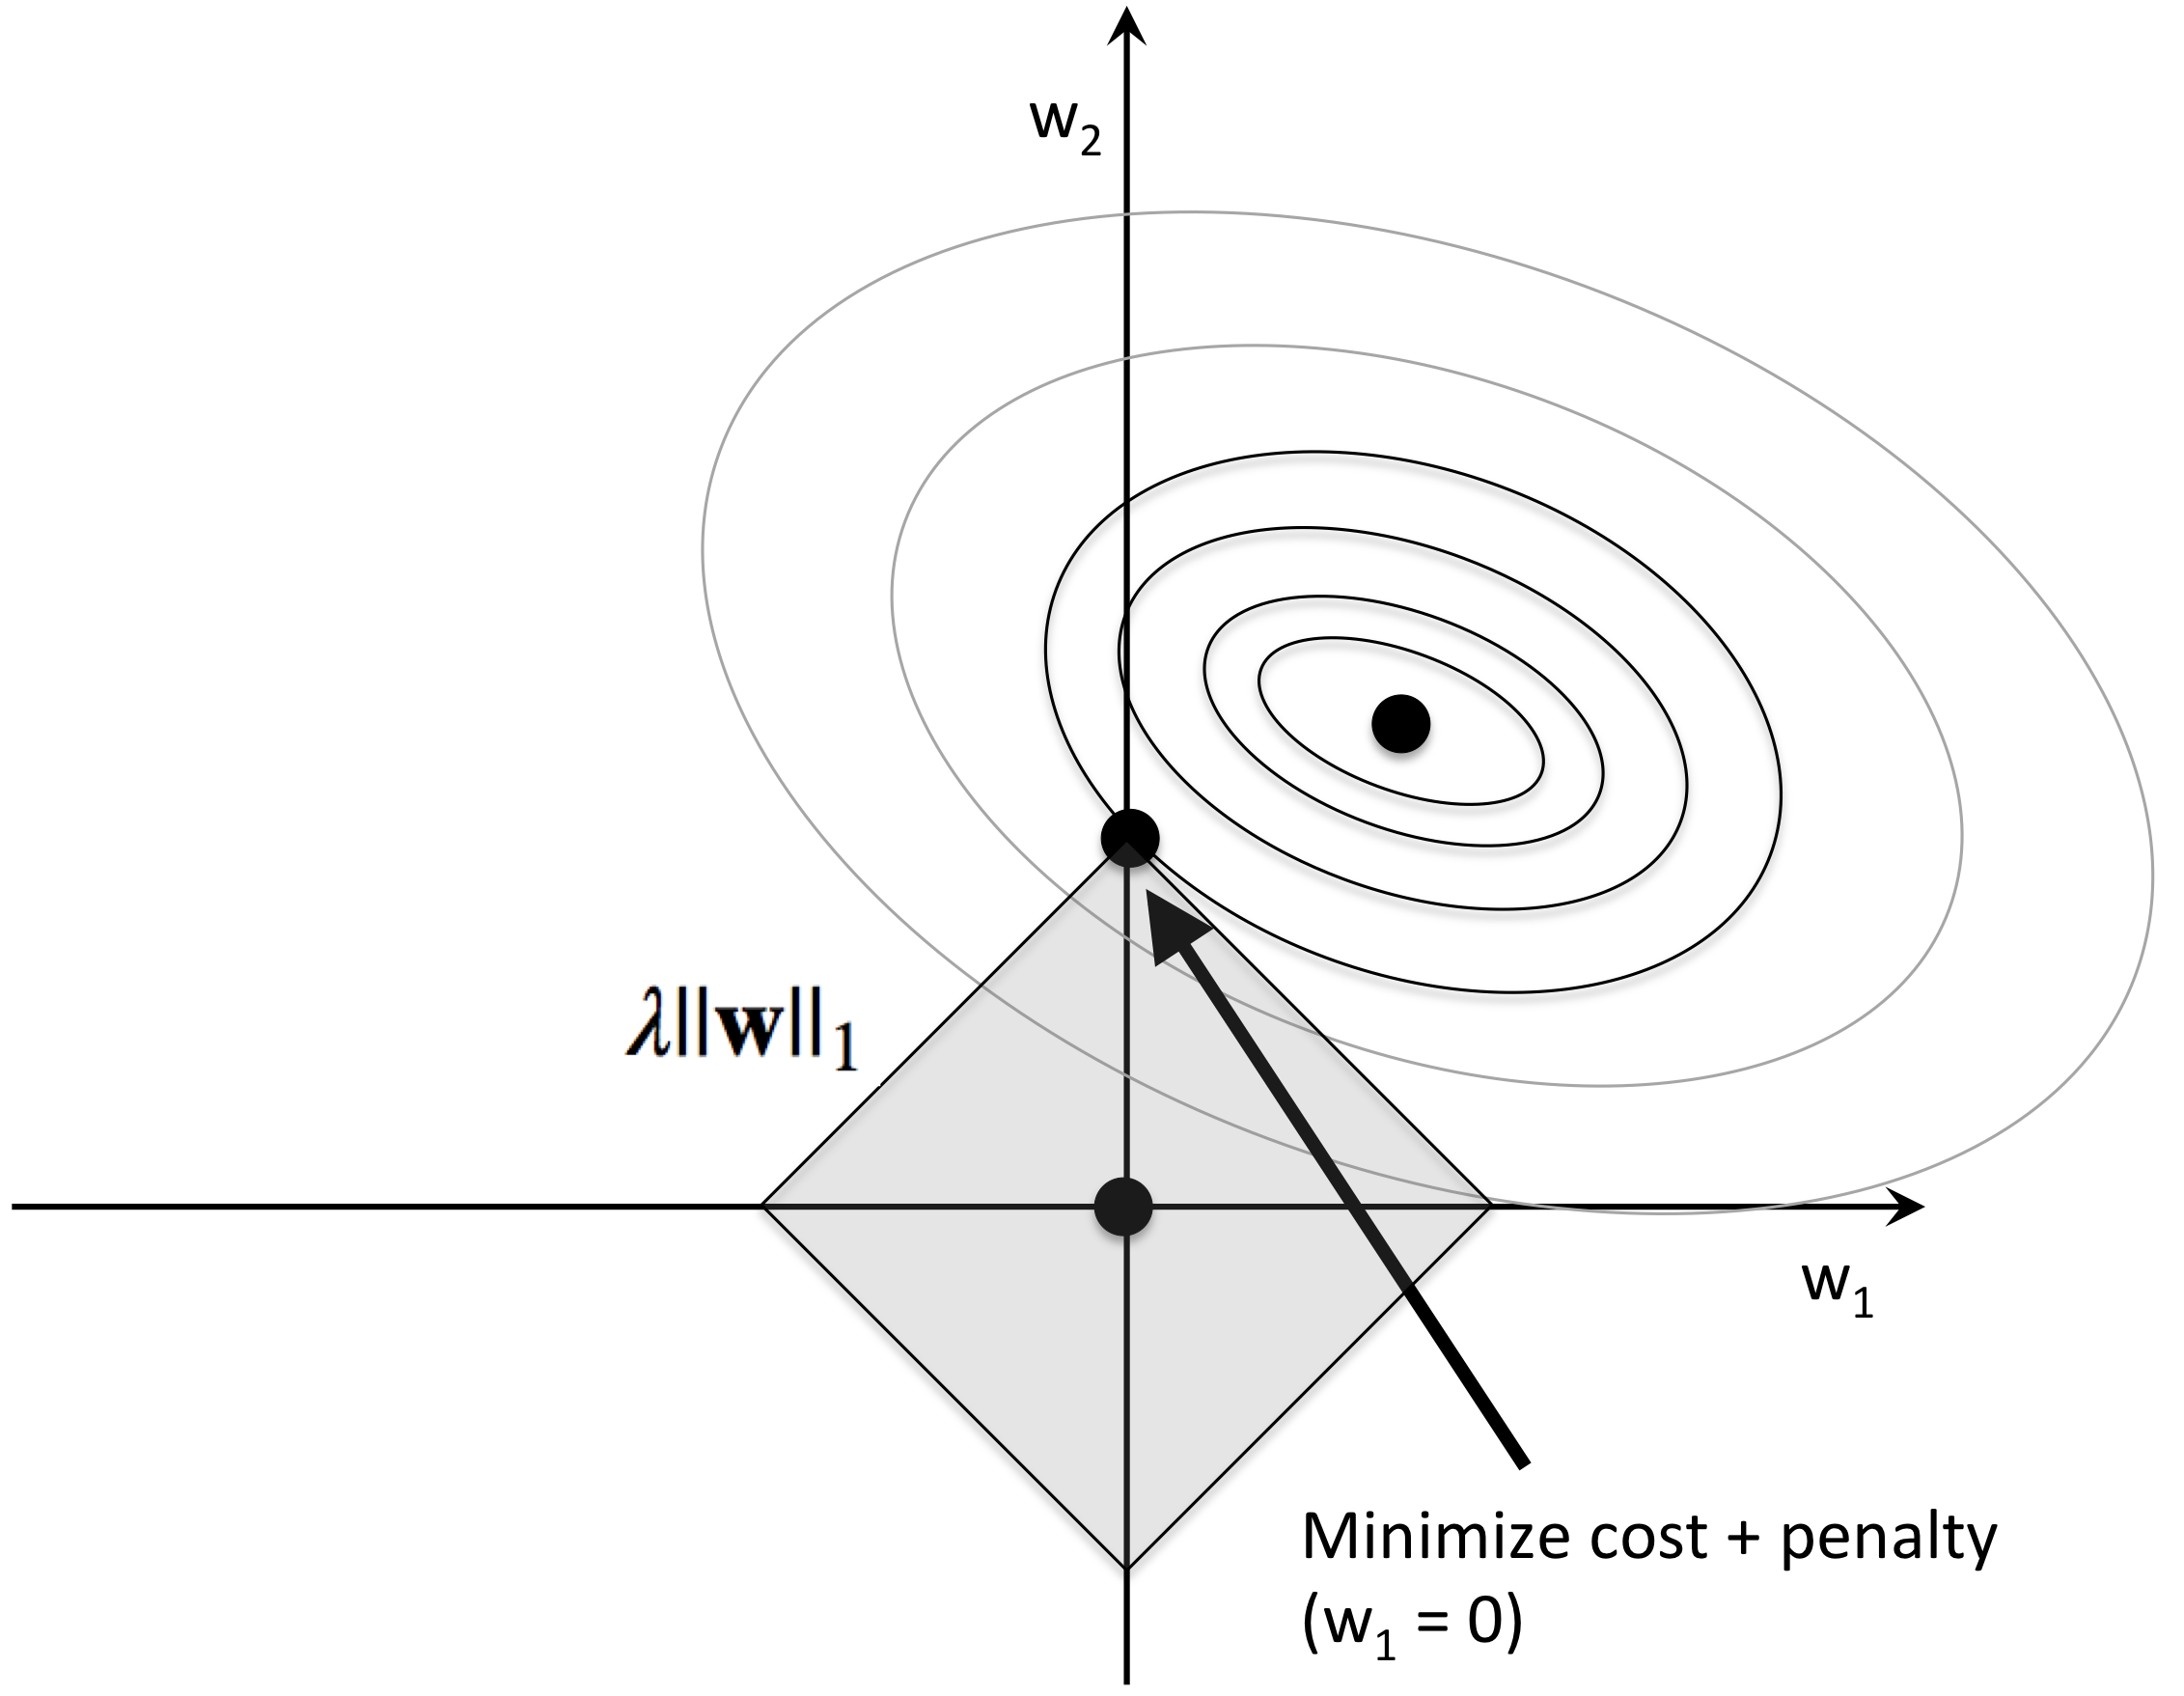

In [39]:
Image(filename='./04_13.png', width=500) 

Let's see an example. We perform the wine classification using the logistic regression on wine datasets previously created. This model can make use of different L<sub>x</sub>-norm regularizations.

In [40]:
from sklearn.linear_model import LogisticRegression

# C: float, default=1.0 is the inverse of regularization strength; 
# must be a positive float. Smaller values specify stronger regularization.
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 1.0


In [41]:
from sklearn.linear_model import LogisticRegression

# C: float, default=1.0 is the inverse of regularization strength; 
# must be a positive float. Smaller values specify stronger regularization.
lr = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
lr.fit(X_train_std, y_train)
print('Training accuracy:', lr.score(X_train_std, y_train))
print('Test accuracy:', lr.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9814814814814815


Let's look at the wine parameter space, in particular how feature's weight coefficients evolve as C parameter changes:

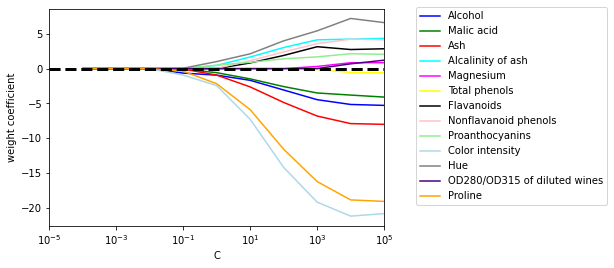

In [43]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)
    
colors = ['blue', 'green', 'red', 'cyan', 
          'magenta', 'yellow', 'black', 
          'pink', 'lightgreen', 'lightblue', 
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0, solver='liblinear')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center', 
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
# plt.savefig('./figures/l1_path.png', dpi=300)
plt.show()

## Sequential feature selection algorithms

Now we use KNN to perform a feature selection through <i>forward selection</i> technique on wine data. 

In [44]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    # constructor of the class, defines the model used, amount of features used and test size
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    # training function
    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

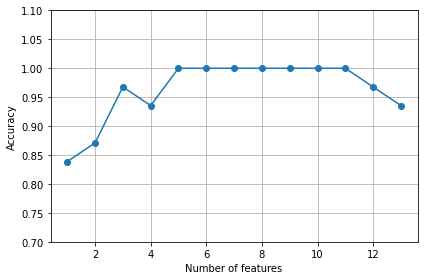

In [45]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [46]:
k5 = list(sbs.subsets_[8])
print(df_wine.columns[1:][k5])

Index(['Alcohol', 'Malic acid', 'Alcalinity of ash', 'Hue', 'Proline'], dtype='object')


In [47]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.9838709677419355
Test accuracy: 0.9444444444444444


In [48]:
knn.fit(X_train_std[:, k5], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k5], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k5], y_test))

Training accuracy: 0.9596774193548387
Test accuracy: 0.9629629629629629


# Assessing Feature Importances with Random Forests

 1) Color intensity                0.182483
 2) Proline                        0.158610
 3) Flavanoids                     0.150948
 4) OD280/OD315 of diluted wines   0.131987
 5) Alcohol                        0.106589
 6) Hue                            0.078243
 7) Total phenols                  0.060718
 8) Alcalinity of ash              0.032033
 9) Malic acid                     0.025400
10) Proanthocyanins                0.022351
11) Magnesium                      0.022078
12) Nonflavanoid phenols           0.014645
13) Ash                            0.013916


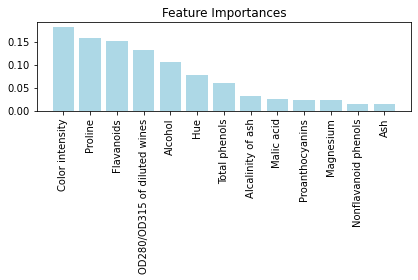

In [49]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('./random_forest.png', dpi=300)
plt.show()

Finally, we mention a recent useful function added within the scikit-learn feature selection class is <b>SelectFromModel()</b>, able to select features based on their importance weights. The argument <i>threshold</i> can be also the "median" or "mean" of the importance distribution. The argument <i>prefit</i> is a flag enabling any internal pre-fitting of the distribution.

In [50]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.15, prefit=True)
X_selected = sfm.transform(X_train)

X_selected.shape

(124, 3)

In [51]:
X_selected

array([[2.880000e+00, 3.800000e+00, 1.035000e+03],
       [2.040000e+00, 2.700000e+00, 3.120000e+02],
       [6.900000e-01, 1.020000e+01, 8.350000e+02],
       [5.500000e-01, 4.000000e+00, 8.300000e+02],
       [2.860000e+00, 3.380000e+00, 4.100000e+02],
       [6.000000e-01, 5.580000e+00, 5.700000e+02],
       [8.300000e-01, 9.010000e+00, 4.800000e+02],
       [2.190000e+00, 3.950000e+00, 1.285000e+03],
       [1.590000e+00, 4.800000e+00, 5.150000e+02],
       [5.800000e-01, 5.450000e+00, 6.500000e+02],
       [2.500000e+00, 2.900000e+00, 4.280000e+02],
       [1.250000e+00, 3.400000e+00, 3.720000e+02],
       [7.000000e-01, 5.280000e+00, 6.750000e+02],
       [1.790000e+00, 3.800000e+00, 6.300000e+02],
       [3.240000e+00, 5.680000e+00, 1.185000e+03],
       [5.700000e-01, 1.950000e+00, 5.200000e+02],
       [2.270000e+00, 2.600000e+00, 9.370000e+02],
       [9.900000e-01, 2.500000e+00, 6.250000e+02],
       [2.630000e+00, 4.360000e+00, 6.800000e+02],
       [3.320000e+00, 5.750000e

<br>
<br>